# Introduction
---
In this project we will use Python and popular network analysis library NetworkX to analyze [this](https://www.kaggle.com/datasets/anshulmehtakaggl/github-organizations-social-network-analysis) social network found on Kaggle. The network is a series of connections between organisations and contributors who use GitHub, a popular platform for collaborative software development. GitHub serves as a hosting platform where individuals and organisations can store and manage their code repositories. In this network analysis project, we aim to leverage Python, with a particular focus on the NetworkX library, to gain insights into the collaborative relationships within this GitHub-based social network.

We'll go through these sections:


- Overview and Preprocessing
- Network Construction
- Basic Measures
- Centrality
- Clique Analysis
- Percolation




# Overview and Preprocessing
---

Let's start as always by loading in all required libraries and modules and viewing our data.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import pickle
import os

In [2]:
file_path = '/Users/danielanderson/Documents/Portfolio/Network_Analysis/organization.csv'

# Reading in the data.
df = pd.read_csv(file_path)

# Looking at the first 10 entries.
df.head(10)

,Organisation,member
0,ethereum,Oleh Aldekein
1,ethereum,NaN
2,ethereum,Frank Szendzielarz
3,ethereum,Kolby Moroz Liebl
4,ethereum,Marius van der Wijden
5,ethereum,Mihai Alisie
6,ethereum,NaN
7,ethereum,Anton Nashatyrev
8,ethereum,Justin Martin
9,ethereum,RJ Catalano


^

The dataset is conveniently held in a 'comma separated values' file, which means we can easily open and view it with pandas, the de-facto library for data analysis in Python. From looking just at the first ten lines we can see that there's some missing values in the data, which we'll be tackling in a moment. Our dataset is bipartite, which means it consists of two distinct types of nodes, namely organizations and contributors. In a bipartite graph, nodes of one type are only connected to nodes of the other type, and there are no connections between nodes of the same type. In the context of our dataset, this bipartite structure reflects the relationships between organizations on GitHub and their associated contributors. This unique network arrangement allows us to explore collaborative patterns and interactions between these two distinct entities in the GitHub ecosystem.

Before we introduce the data into NetworkX we can get some basic insights from pandas, let's have a look at the size of the dataset as a whole and which organisations have the most and least contributors.

In [3]:
# Let's count the total number of edges.
print('Total number of edges:', len(df))

# We'll check how many contributors are in the top 10 and 
# bottom 5 Organisations.
print('\nTop 10 organisations and their number of contributors:\n'\
      ,df['Organisation'].value_counts()[:10]\
      , '\n\nBottom 5 Organisations ad their number of contributors:\n'\
      ,df['Organisation'].value_counts()[-5:])

# We'll also get an idea of how many organisations and people there are.
print(f'\n\nNumber of organisations: {len(df["Organisation"].unique())}')
print(f'Nunber of contributors: {len(df["member"].unique())}')

Total number of edges: 10598

Top 10 organisations and their number of contributors:
 Organisation
microsoft    4362
Azure        1931
apache       1123
google        877
nodejs        370
aws           180
elastic       173
reactjs       147
python        119
facebook      110
Name: count, dtype: int64 

Bottom 5 Organisations ad their number of contributors:
 Organisation
opencv     10
nuxt        7
reduxjs     6
redis       5
udacity     5
Name: count, dtype: int64


Number of organisations: 41
Nunber of contributors: 8879


^

The dataset has over 10 thousand edges.

No surprise in the largest companies here, Microsoft, Azure, Google etc... The top two companies represent over half the dataset with 6293 contributors. While the remaining 39 companies only amount to 4305 contributors. The bottom 5 organisation's contributors sum up to a mere 33.



Let's plot this for a more visually appealing and understandable view.

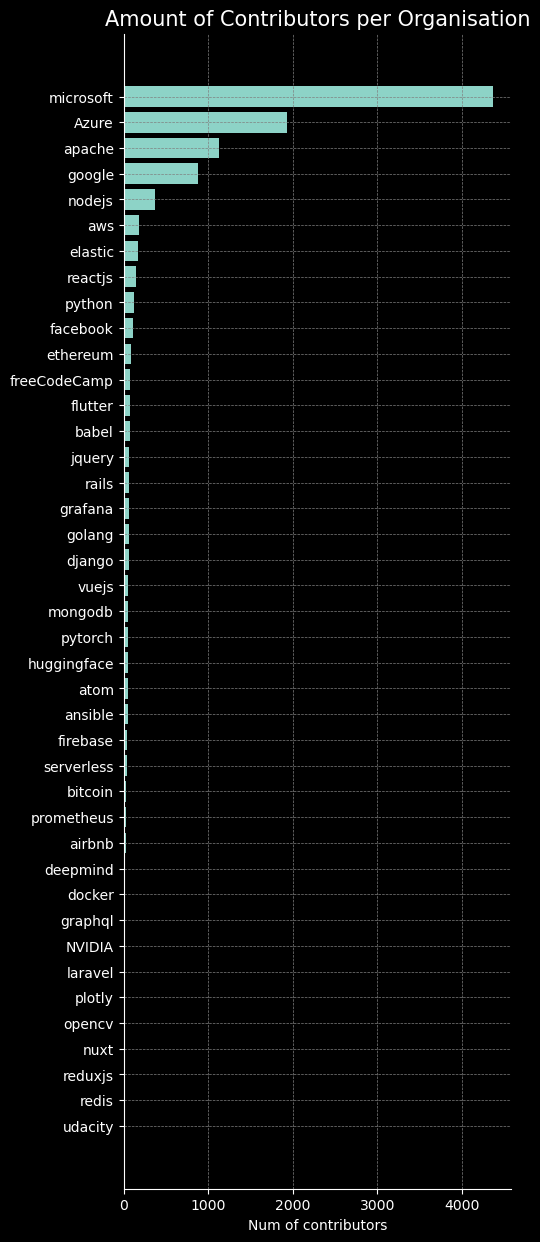

In [4]:
# Setting the style to keep plots looking similar.
# As always, I prefer the dark background.
plt.style.use('dark_background')

# Reversing the data, since it makes more sense for 
# the high numbers to be on the top.
orgs = []
membs = []

for org, mem in zip(df['Organisation'].value_counts().index,
                    df['Organisation'].value_counts()):
    orgs.append(org)
    membs.append(mem)

orgs.reverse()
membs.reverse()

# Plotting a horizontal bar chart.
plt.figure(figsize=(5,15))
plt.barh(orgs, membs)

plt.title('Amount of Contributors per Organisation', size =15)
plt.xlabel('Num of contributors')

# Styling.
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

^

There's a quick reduction in the number of contributors after the fifth highest company.

Let's get some basic information about contributors. 

In [5]:
# Let's check how many contributors an organisation has on average.
avg_contributors_per_org = df.groupby('Organisation')['member'].nunique().mean()
print(f'Average number of contributors per organisation:'\
      f' {avg_contributors_per_org:.2f}')

# Who contributes the most.
print('\n\n Top 10 contributors:\n', df['member'].value_counts()[:10])

# How many organisations does a contributor work for 
# on average.
print('\n\nAverage number of organisations that a contributor has worked for:',
      f'{df["member"].value_counts().mean():.2f}')

Average number of contributors per organisation: 234.85


 Top 10 contributors:
 member
Daniel             4
Thomas Watson      3
Darcy Clarke       3
Derek              3
Ryan Wilson        3
Strong Liu(刘少壮)    3
Xin Shi            3
Lucas Santos       3
Matthew Dempsky    3
David Li           3
Name: count, dtype: int64


Average number of organisations that a contributor has worked for: 1.09


^

We can see that the average number of contributors per organisation is 235, these numbers are clearly skewed by the larger organisations as seen above, since we know that 31 organisations (out of 41) have fewer than 110 contributors. This skew is further highlighted in the average number of organisations that a contributor works for: 1.09. Only slightly over one, the **top** contributor (Daniel) has only worked with four organisations.

Let's take a quick look at Daniel's history with GitHub.

In [6]:
df[df['member'] =='Daniel']

,Organisation,member
1109,google,Daniel
1987,apache,Daniel
6402,microsoft,Daniel
6404,microsoft,Daniel


^

It looks like Daniel has contributed to three different companies and twice to the same organisation. Before we start using NetworkX let's get a quick visualization showing how many people contributed a given number of times.

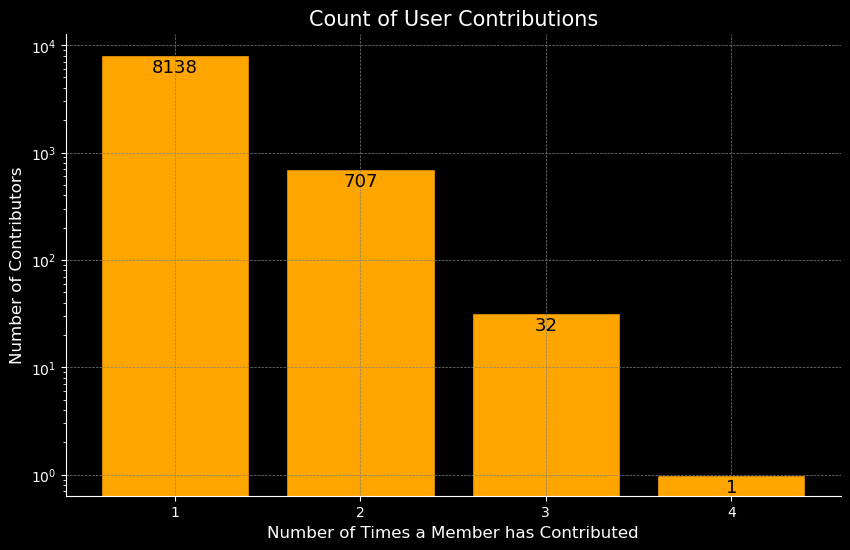

In [7]:
# Calculate the amount of people contributing 1,2,3 or 4 times.
contribution_count = df['member'].value_counts().value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(contribution_count.index, contribution_count,
        color='orange', edgecolor='black', log=True)


plt.title('Count of User Contributions', size=15)
plt.xlabel('Number of Times a Member has Contributed', size = 12)
plt.xticks([1,2,3,4])
plt.ylabel('Number of Contributors', size = 12)

# Looping over the bars to overlay the actual quantities.
# Since the log-scale can be difficult to interpret for some. 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.37 * yval, int(yval),
             ha='center', va='bottom', fontsize=13, color='black')

# Styling
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

^

Here we can see that, by far, most users only make one contribution, with less than ten percent making more.

Note here, that a **log scale** was used to visualize the difference, it makes it appear that 3 and 4-time contributors have more numeric influence, on a regular scale we'd only be able to see 1 and 2-time contributors due to the fact that there's so much more.

Ok, let's check out the NULL values that we looked at in the beginning. 

In [8]:
# Checking how many NULL entries we have in the member column.
len(df[df['member'].isna()])

946

In [9]:
# Checking the Organisation column.
len(df[df['Organisation'].isna()])

0

^

Wow! Almost a tenth of our data is NULL. If we Remove these NULL entries, we'll still leave over 9000 edges in our dataset.

Likely causes of such NULL values could be:
- An error when scraping the data from GitHub; perhaps the algorithm used to scrape the data didn't account for some variable and the resulting 'default' was a NULL value.
- The GitHub API could have changed since writing the code.
- User Privacy settings. Maybe some of the contributors don't want their aliases being shared, after all, users of a coding website like GitHub will be aware of web scraping and company APIs.

As concerning as it is that 900 edges may be useless to this project, there's no way to get the true values now that the dataset is over a year old. Rather than simply discarding the NULL-value nodes (contributors) we'll store them in a separate dataset, just in case we want to look at them later. But for now, we'll focus on the data that's complete. 

In [10]:
# Separating our data into a NULL dataframe and the 
# regular, now NULL-free, dataframe.

df_NULL = df[df['member'].isna()]

df = df.dropna(subset=['member'])

In [11]:
print('Amount of entires dropped:', len(df_NULL))
print('Remaining entires:', len(df))

Amount of entires dropped: 946
Remaining entires: 9652


^

Great, now with NULL values accounted for, let's check for duplicated values, and we'll make a decision based on what we find.

In [12]:
# Finding the amount of rows where both columns are 
# exactly the same.
print('Amount of duplicated entries:', len(df[df.duplicated()]))

# Taking a quick look.
df[df.duplicated].head()

Amount of duplicated entries: 23


,Organisation,member
1890,apache,Joey
2291,apache,Alex
2382,apache,Xin Wang
2473,apache,Lee
6404,microsoft,Daniel


^

Interesting. We can see that there's 23 duplicated entries out of a total of 9652. We previously saw that 'Daniel' had two entries which were the same and we can see his duplicate in the view that we have above. There are a few options when it comes to duplicates in a social network, like:

1. **Aggregate Edge Attributes:**
   - We could combine information from duplicate edges.

2. **Weighted Edges:**
   - If our graph was weighted, we could consider assigning weights to the edges to reflect the intensity or frequency of interactions. Duplicate edges could contribute to the overall weight of the connection.

4. **Graph Projection:**
   - Since our graph is bipartite, we could project it onto a unipartite graph to focus on the relationships between contributors or organizations. This can simplify the structure and potentially reduce the impact of duplicates.
   
However, since we're presuming that each duplicate entry accounts for a genuine contribution to the same organization by the same person, we're going to simply conserve the data as-is. Had there been more duplicates, we could have chosen to create a MultiGraph, which allows for multiple edges from the same two nodes, but since the quantity is low, we're going to create a regular undirected bipartite graph, which doesn't account for duplicate edges, effectively removing them.

# Network Construction
---

Now that the data has been prepared, we'll move on to the next step in our project, constructing and viewing our bipartite graph. Building upon the cleaned and preprocessed dataset, our objective is to create a comprehensive representation of the collaborative relationships between organizations and contributors within the GitHub-based social network.

We will use the NetworkX library in Python to construct the bipartite graph, where nodes represent both organizations and contributors, and edges denote collaborative interactions. 

In [13]:
# We'll import the bipartite algorithm from networkx
from networkx.algorithms import bipartite

# Instantiate our bipartite graph as 'B'. The typical name would be 'G', 
# like 'df' in pandas, but since it's bipartite we'll name it 'B'.
B=nx.Graph()

# Adding one side 'bipartite 0' from the Organisations.
B.add_nodes_from(df['Organisation'], bipartite = 0)
# The other side from the contributors.
B.add_nodes_from(df['member'], bipartite = 1)

# Adding the edges between the nodes.
for i in range(len(df)):
    B.add_edges_from([(df.iloc[i,1], df.iloc[i,0])])

In [14]:
# Let's quickly check if it's truly bipartite.
nx.is_bipartite(B)

True

^

The check above tells us that the network is truly bipartite.

Let's take a look.

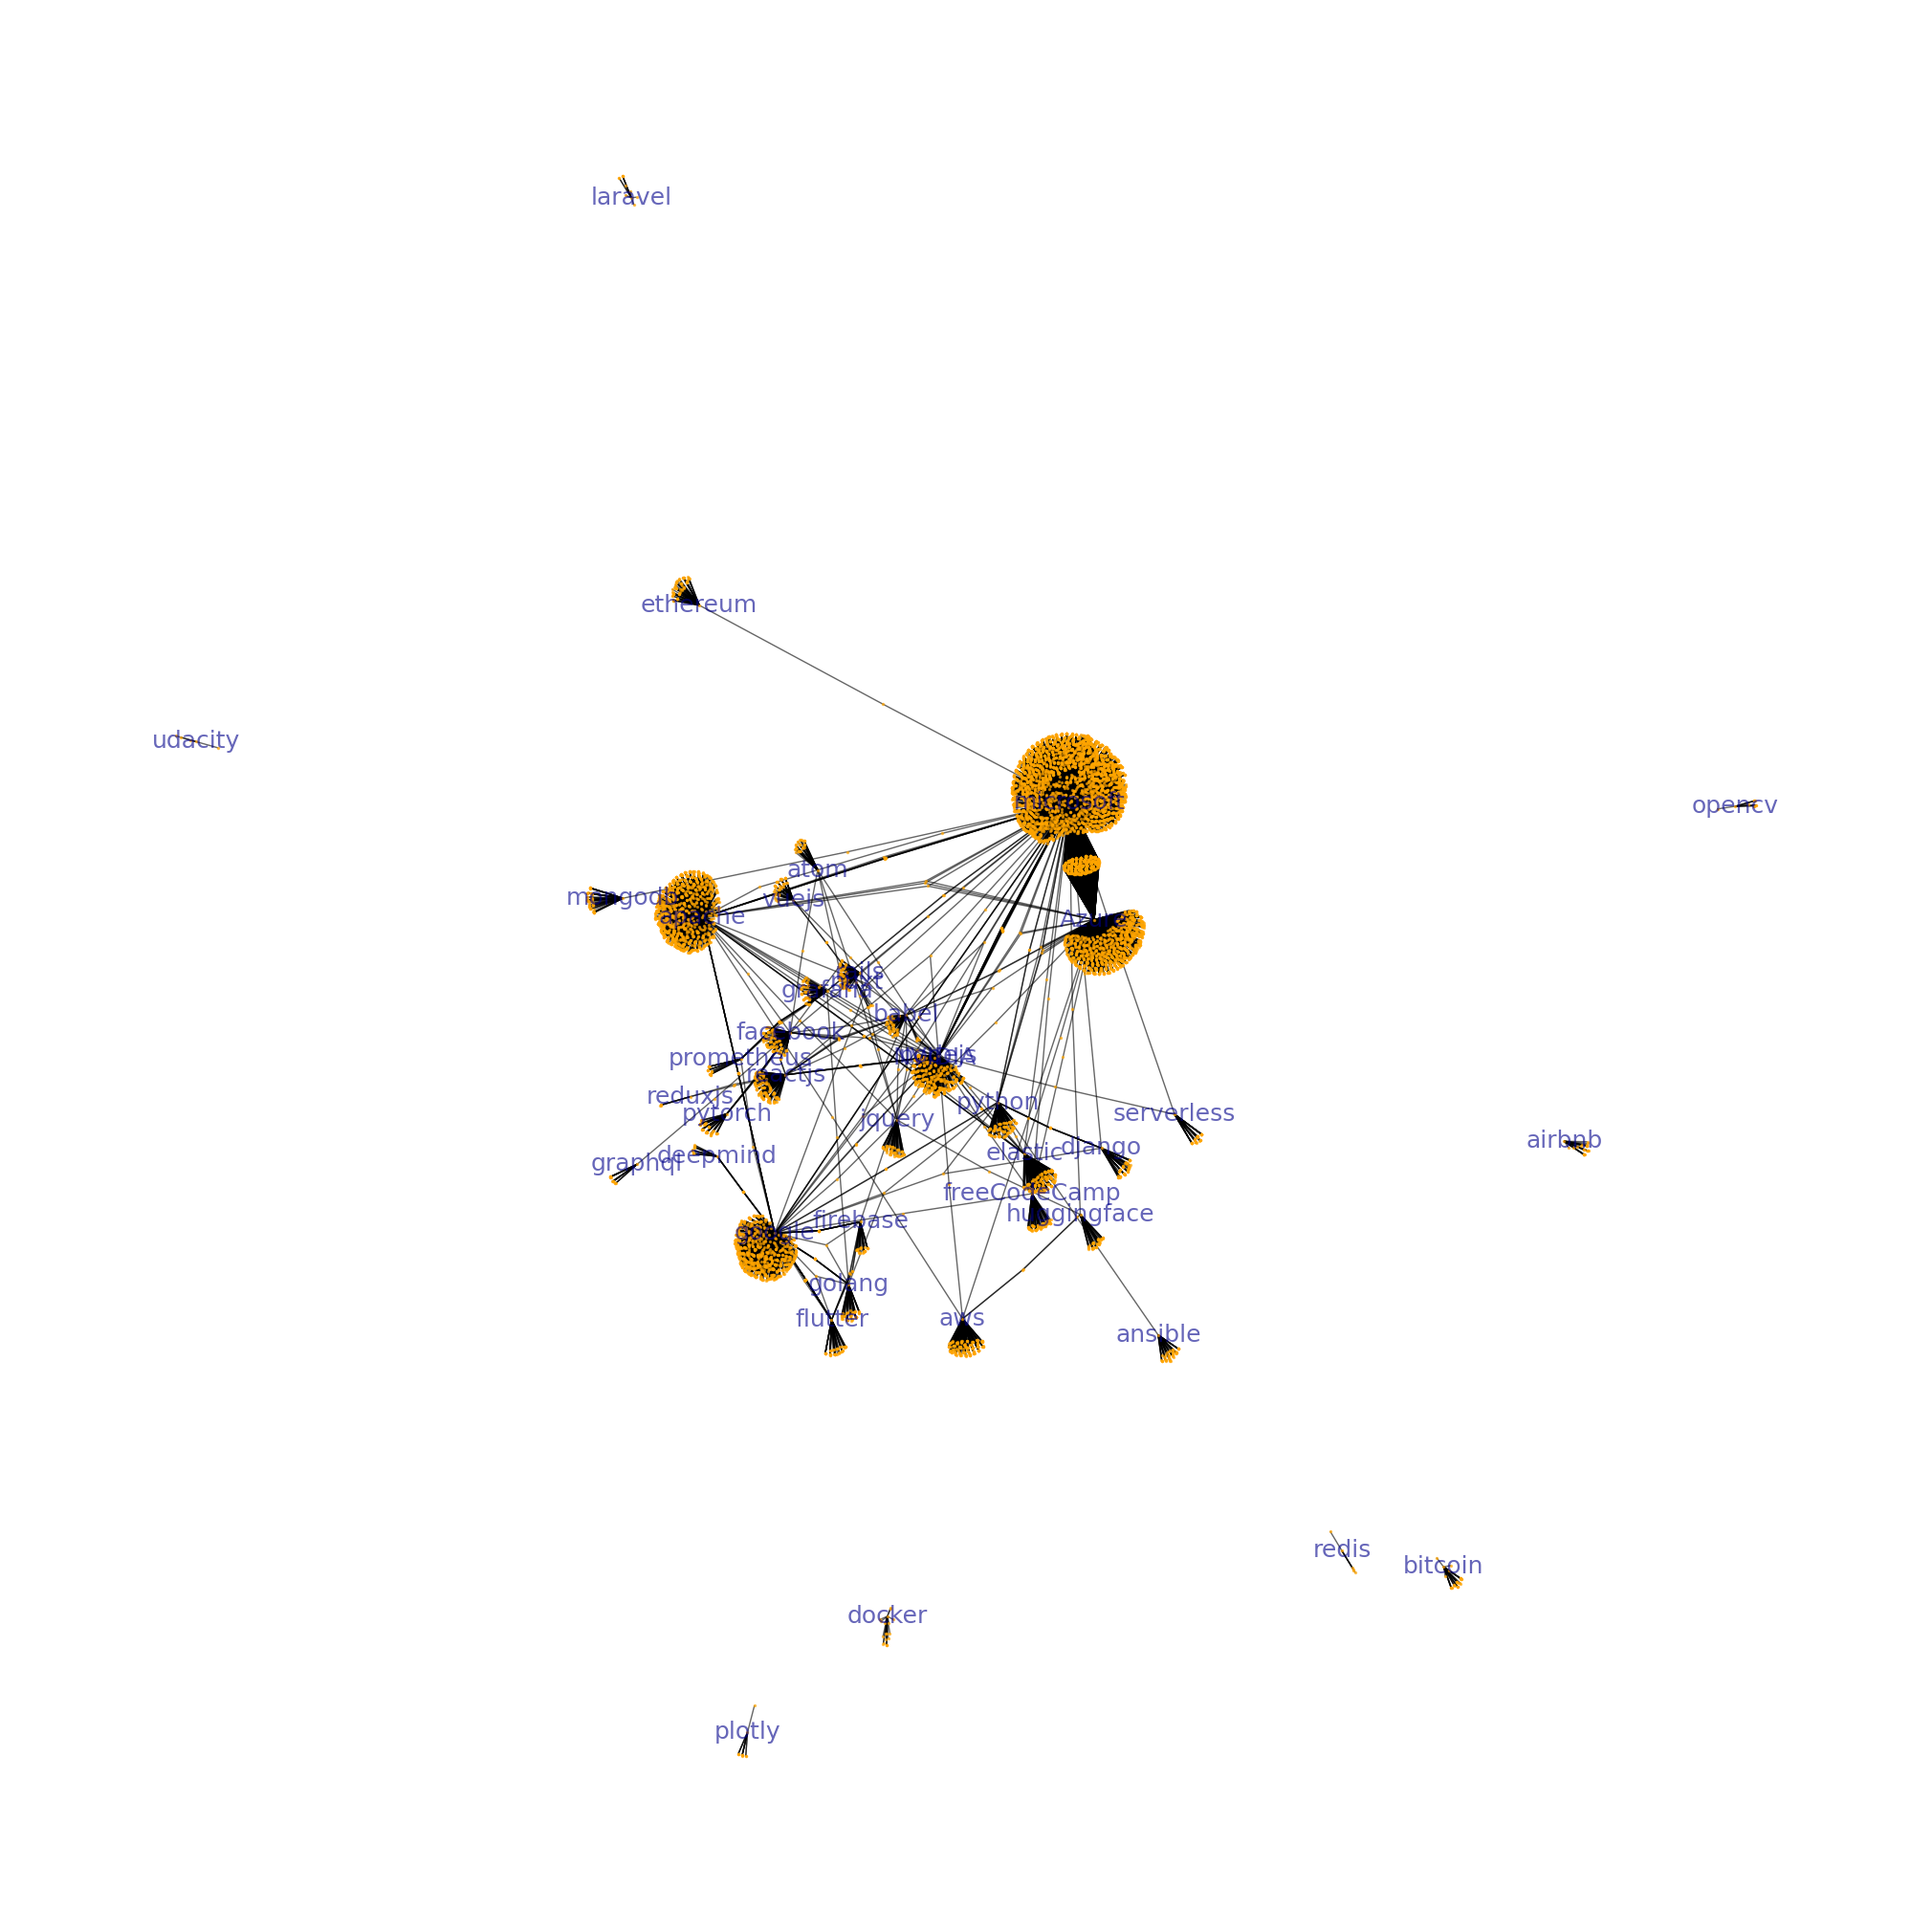

In [15]:
# Selecting only the organisation names.
organization_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}

labels_dict = {n: n for n in organization_nodes}
plt.figure(figsize=(20,20))

nx.draw_spring(B,
              node_size=2,
              alpha = 0.6,
              node_color = 'orange',
              with_labels = True,
              labels = labels_dict,
              font_size = 18,
              font_color = 'darkblue'
              )
plt.show()

^

We can see here that our social-network has a main connected component, with other smaller components surrounding it. A connected component is a subset of nodes within the graph where each node is reachable from every other node in the same subset through a path, and no path connects nodes from different subsets. In the context of our visualization, the main connected component suggests a cohesive and tightly interconnected core within the social network, while the smaller components may represent more isolated or specialized communities of contributors and organizations.

For the sake of visual clarity, the names of the contributors were omitted from this visualization.

As was evident from the overview, we have clusters of contributors around a single node - an organisation - creating flower-like shapes, where the petals could be thought of as the people and where they join at the stem is the organisation. Although relatively difficult to read, we can once again see here that the organizations with the most contributors are Microsoft, Azure, Apache and Google.

To confirm what we see here with numbers, let's have NetworkX tell us how many connected components there are.

In [16]:
nx.number_connected_components(B)

9

^

Great. Before we move onto measures of centrality, let's create a sub-graph from our main graph of the largest connected component (seen in the centre of our visualization above). This way we can use its connectedness to gain insights on some basic measures.


# Basic Measures
---
In this section we'll implement some of NetworkX's functions to get a numeric overview of our dataset.

In [17]:
# We'll find our largest connected component.
largest_connected_component_nodes = max(nx.connected_components(B), key=len)

# Then create a new graph just for this.
B_main = B.subgraph(largest_connected_component_nodes).copy()

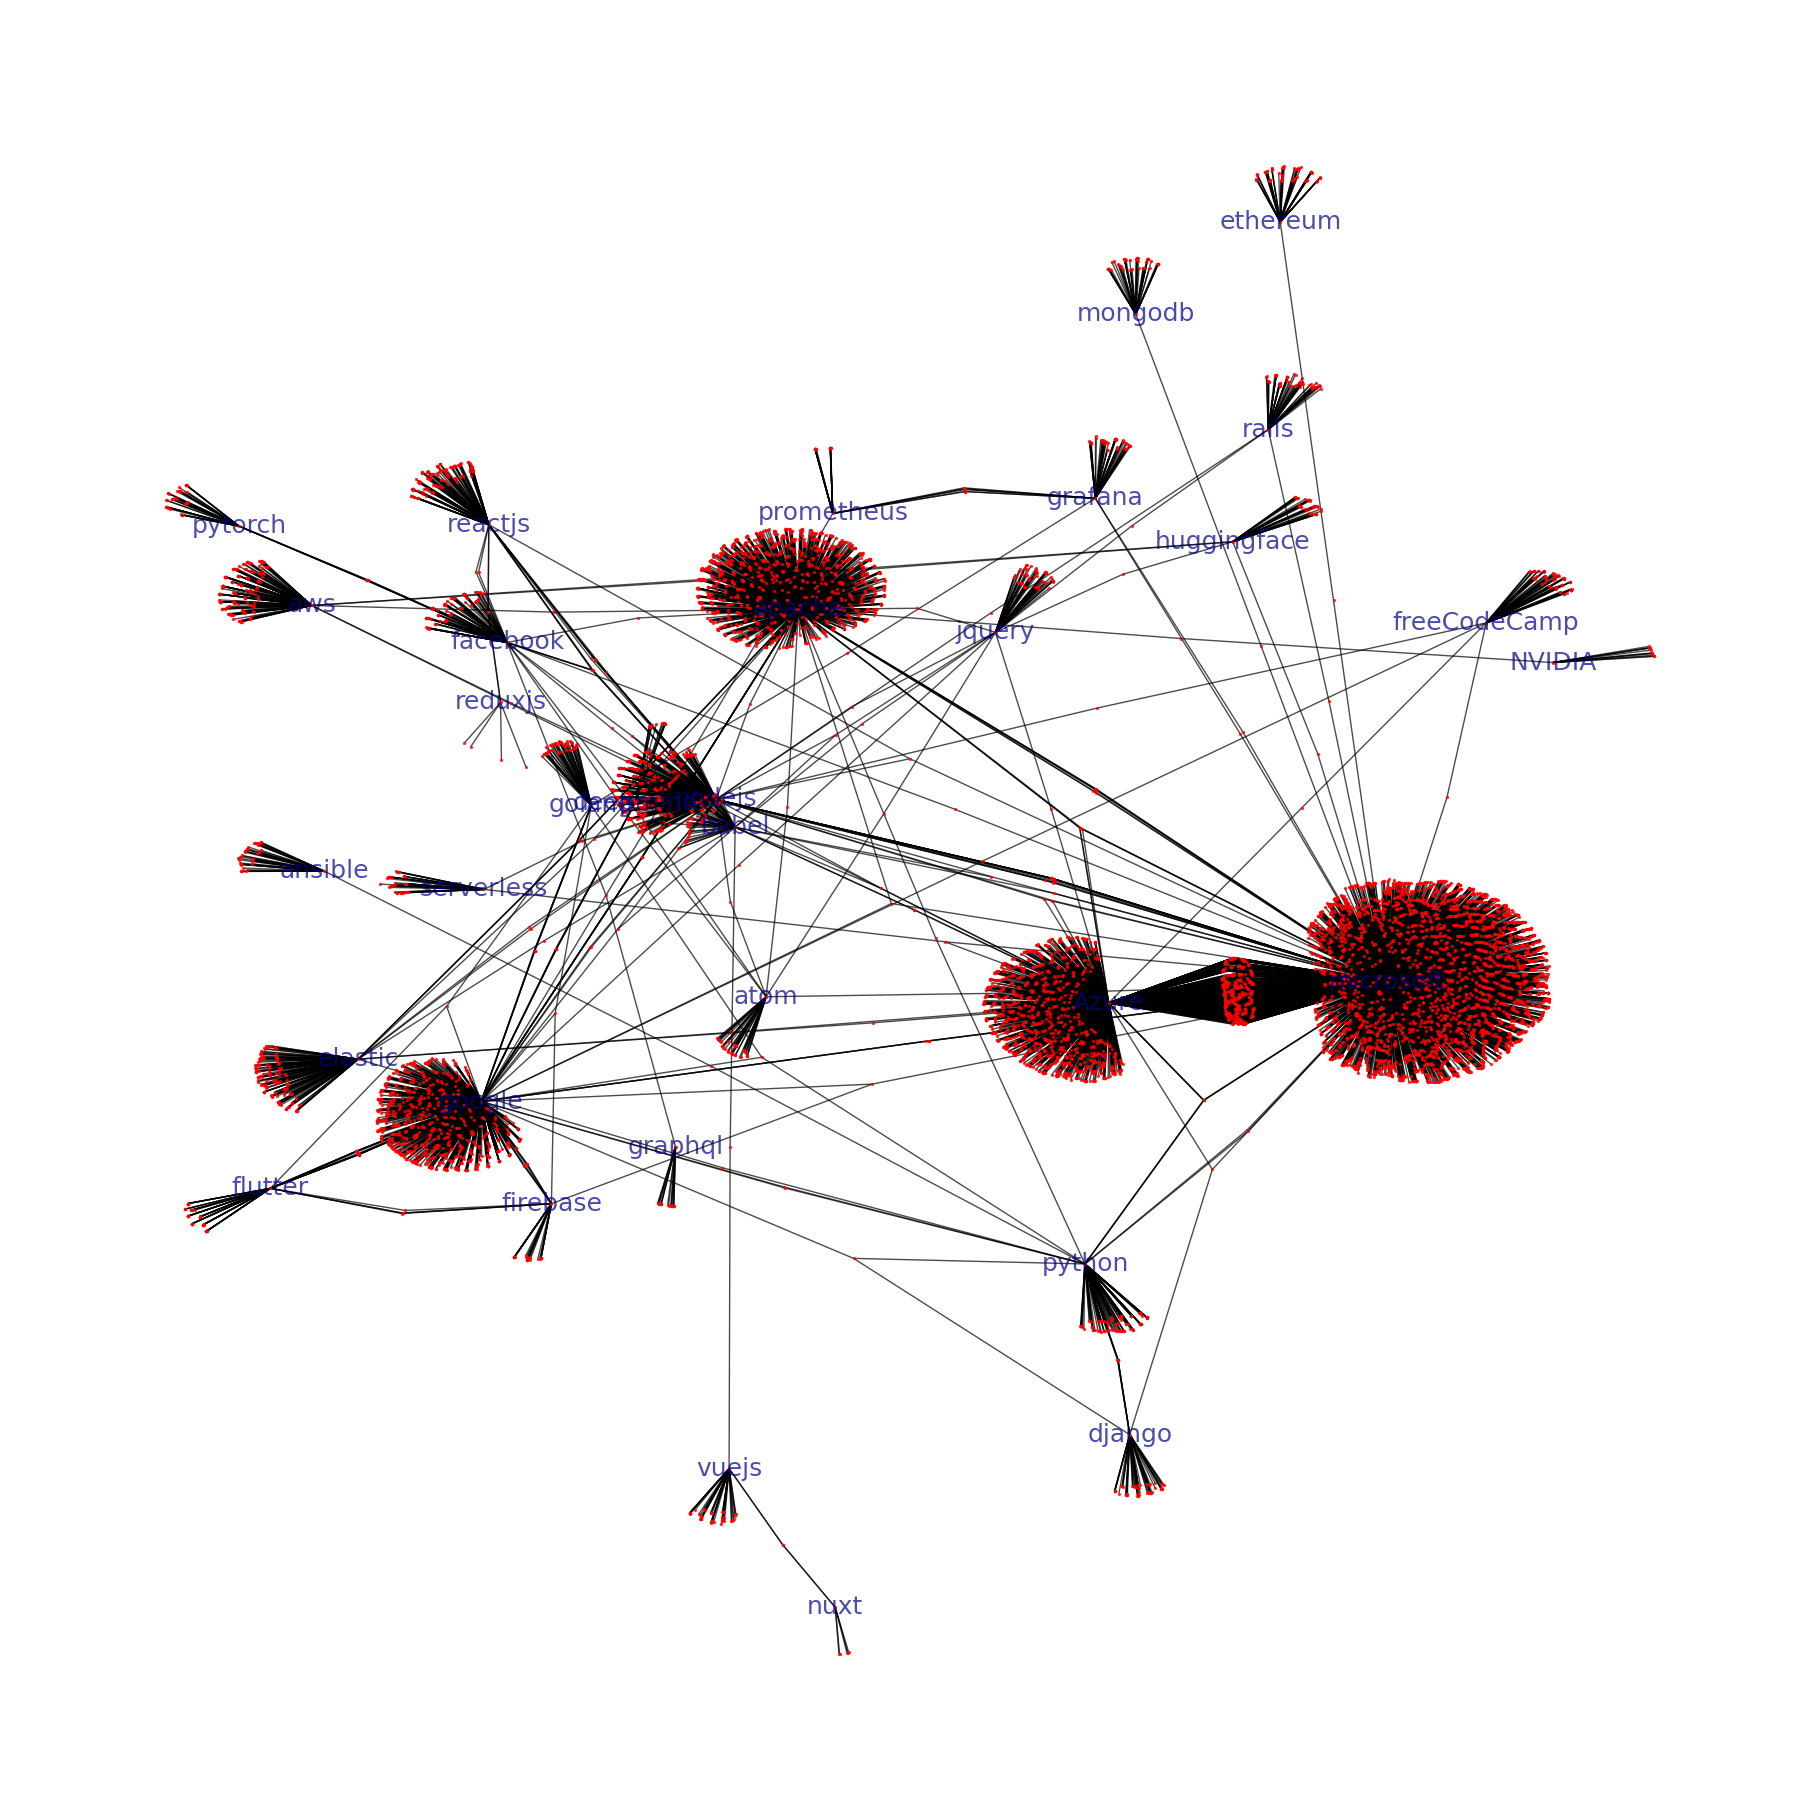

In [18]:
# Let's plot our graph
organization_nodes_main = {n for n, d in B_main.nodes(data=True) if d['bipartite'] == 0}

labels_dict_main = {n: n for n in organization_nodes_main}
plt.figure(figsize=(18,18))

nx.draw_spring(B_main,
              node_size=2,
              alpha = 0.7,
              node_color = 'red',
              with_labels = True,
              labels = labels_dict_main,
              font_size = 18,
              font_color = 'darkblue'
              )
plt.show()

In [19]:
print(f'Is the whole graph connected?: {nx.is_connected(B)}')
print(f'Is B_main connected?:          {nx.is_connected(B_main)}')

Is the whole graph connected?: False
Is B_main connected?:          True


^

Ok, we can see by confirming with NetworkX that our sub-graph `B_main` is fully connected. Which allows us to utilize a few more techniques with NetworkX to gain extra insight into our social network.

Let's take a look at some of the basic measures that NetworkX provides.

In [20]:
# Basic measures of the main subgraph.
print(f'Density:        {nx.density(B_main):.2f}\n')

print(f'Diameter:       {nx.diameter(B_main):.2f}\n')
                   
print(f'Radius:         {nx.radius(B_main):.2f}\n')
                   
print(f'Avg short path: {nx.average_shortest_path_length(B_main):.2f}\n')

print(f'Avg clustering: {nx.algorithms.bipartite.average_clustering(B_main):.2f}\n')

print(f'Num of bridges: {len(list(nx.bridges(B_main))):.2f}')

Density:        0.00

Diameter:       12.00

Radius:         6.00

Avg short path: 3.88

Avg clustering: 0.89

Num of bridges: 8055.00


^

Let's quickly discuss what each of these mean for our dataset.

- The **density** of 0.00 indicates a very sparse graph. In a bipartite graph, this suggests that only a small fraction of possible connections between organisations and contributors are present, which agrees with our visualization.
- The **diameter** of 12.00 is the longest 'shortest path' between any pair of nodes in the graph. In our case, it indicates that the maximum distance (number of edges) between any two nodes in our main subgraph is 12.
- The **radius** of 6.00 is the minimum eccentricity among all nodes in the graph. In other words, the distance from the center to the furthest node is 6. This measure provides insights into the overall size and structure of the graph, letting us know that with a maximum of 6 steps, you can get from the edge to the centre of our graph.
- The **average shortest path length** is 3.88, which is the average number of edges on the shortest path between all pairs of nodes. This provides a sense of how well-connected the graph is on average, in other words; within our main connected component `B_main` it would take an average of 3.88 hops for information to propagate from one node to another.
- The average **clustering coefficient** is 0.89, indicating a relatively high level of clustering or local connectivity in the graph. This suggests that nodes in our bipartite graph tend to form tightly knit groups, observed in the flower-like structures in our visualization.
- The number of **bridges** is 8055, which are edges that, if removed, would increase the number of connected components in the graph (split the data). In a bipartite network, bridges play a crucial role in connecting the two partitions. In the case of our data, many of the contributor nodes are only joined to one other node: their organisation-node, so disconnecting this edge would naturally create another connected component (unconnected set of nodes).


For our reference, we'll check out which nodes are at the centre of our graph.

In [21]:
# Getting the central nodes.
print(nx.center(B_main))

['Benedikt Meurer', 'Daniel Rosenwasser', 'F. Hinkelmann', 'Vignesh Shanmugam', 'James', 'Paul Miller', 'Keith Cirkel']


^

These nodes have to travel at least 6 steps to arrive at the edge (or periphery) of our graph, indicating centrality and potential influence.

Let's move on to the next part - measures of centrality.

# Centrality
---

Centrality provides valuable insights into the significance and influence of nodes within the network, shedding light on key contributors and pivotal organisations. By calculating metrics such as degree centrality, betweenness centrality, and closeness centrality, we aim to identify and interpret the important nodes that play crucial roles in connecting and influencing the broader network.

In [22]:
# We'll start with the three most common types of centrality.

# Degree Centrality
degree_cent = nx.degree_centrality(B)

# Betweenness Centrality
betweenness_cent = nx.betweenness_centrality(B)

# Closeness Centrality
closeness_cent = nx.closeness_centrality(B)

# Looking at a 9000 item dictionary wont be insightful,
# nor pleasing to the eye...
# We'll look at the average centrality instead.
avg_degree_cent = sum(degree_cent.values()) / len(degree_cent)
avg_betweenness_cent = sum(betweenness_cent.values()) / len(betweenness_cent)
avg_closeness_cent = sum(closeness_cent.values()) / len(closeness_cent)

# Getting the max and min values for each centrality.
max_deg_cent, max_deg_cent_val = max(degree_cent.items(), key=lambda x: x[1])
min_deg_cent, min_deg_cent_val = min(degree_cent.items(), key=lambda x: x[1])

max_betw_node, max_betw_cent_val = max(betweenness_cent.items(), key=lambda x: x[1])
min_betw_node, min_betw_cent_val = min(betweenness_cent.items(), key=lambda x: x[1])

max_clos_node, max_clos_cent_val = max(closeness_cent.items(), key=lambda x: x[1])
min_clos_node, min_clos_cent_val = min(closeness_cent.items(), key=lambda x: x[1])


# Printing out results.
print(f'Average Degree Centrality: {avg_degree_cent:.4f}')
print(f'  Node with highest degree centrality: {max_deg_cent}\
 {max_deg_cent_val:.4f}')
print(f'  Node with lowest degree centrality:  {min_deg_cent}\
 {min_deg_cent_val:.4f}')
print('\n  -------  \n')
print(f'Betweenness Centrality: {avg_betweenness_cent:.4f}')
print(f'  Node with highest betweenness centrality: {max_betw_node}\
 {max_betw_cent_val:.4f}')
print(f'  Node with lowest betweenness centrality: {min_betw_node}\
 {min_betw_cent_val:.4f}')
print('\n -------  \n')
print(f'Closeness Centrality: {avg_closeness_cent:.4f}')
print(f'  Node with highest closeness centrality: {max_clos_node}\
 {max_clos_cent_val:.4f}')
print(f'  Node with lowest betweenness centrality: {min_clos_node}\
 {min_clos_cent_val:.4f}')

Average Degree Centrality: 0.0002
  Node with highest degree centrality: microsoft 0.4391
  Node with lowest degree centrality:  Oleh Aldekein 0.0001

  -------  

Betweenness Centrality: 0.0003
  Node with highest betweenness centrality: microsoft 0.7177
  Node with lowest betweenness centrality: Oleh Aldekein 0.0000

 -------  

Closeness Centrality: 0.2599
  Node with highest closeness centrality: microsoft 0.4426
  Node with lowest betweenness centrality: Jacob Walker 0.0003


^

Let's discuss each of these one by one:

1. **Degree Centrality**
    - On average our network has a degree centrality of 0.0002, which is relatively low. Nodes with high degree centrality are well connected to other nodes, we know from the preprocessing stage that companies have many connections and contributors have relatively few, the average being so low suggests skew in our dataset, which was also observed in the preprocessing stage.
    - Microsoft has the highest degree centrality at 0.4391, where 1 would represent connections to **all** the nodes. In our particular network it was obvious that a company, and after our initial overview it was evident *which* company, would have the highest degree centrality.
    - The node with the lowest degree centrality, and therefore the least well-connected to many other nodes, is Oleh Aldekein.
2. **Betweenness Centrality**
    - Like the average degree centrality, the average betweenness centrality is fairly low at 0.0003. Nodes with high betweenness centrality act as bridges or critical points in the network. They play a key role in connecting different parts of the network. Given our bipartite network, this makes sense. There are thousands of contributors who are only connected to one organisation, therefore they don't play the role of a 'bridge', they're simply an adjoining arm to the company.
    - Microsoft also has the highest betweenness centrality (0.7177), indicating that it plays a crucial role in connecting different parts of the network. If Information was passing through the network randomly, it is likely to encounter this node. In other words, if a message was to be sent from one random node to another random node, there's a 71% chance that it will pass through the 'microsoft' node.
    - Oleh Aldekein makes another appearance with the lowest betweenness centrality, suggesting that this contributor does not serve as a critical bridge between different parts of the network.
3. **Closeness Centrality**
    - The average closeness centrality in our network is 0.2599, which is relatively high. Implying that, to get from one node to another, on average, a relatively small number of steps or hops is required. Suggesting a (mostly) well connected network where information or influence can efficiently propagate through the nodes.
    - To no surprise, Microsoft is also the node with the highest closeness centrality (0.4426). Suggesting that it is close to many other nodes in the network and can quickly interact with a large portion of the network; demonstrated in our network visualization above, and the preprocessing stage.
    - Lastly, Jacob Walker is the least 'close' to all other nodes with a score of 0.0003.
    

Clear and quantifiable data that Microsoft appears to be the most 'central', and perhaps the mode influential, node in this network.

Let's now investigate two more measures of centrality: Eigenvector Centrality and Page Rank.

In [23]:
# Getting the eigenvector centrality.
eigenvector_cent = nx.eigenvector_centrality(B, max_iter=500)

# A huge dictionary won't be useful.
avg_eign_cent = sum(eigenvector_cent.values()) / len(eigenvector_cent)

# Getting the max and min values for each centrality.
max_eig_cent, max_eig_cent_val = max(eigenvector_cent.items(), key=lambda x: x[1])
min_eig_cent, min_eig_cent_val = min(eigenvector_cent.items(), key=lambda x: x[1])


# Printing out results.
print(f'Average eigenvector centrality: {avg_eign_cent:.4f}')
print(f'  Node with highest eigenvector centrality: {max_eig_cent}\
 {max_eig_cent_val:.4f}')
print(f'  Node with lowest eigenvector centrality:  {min_eig_cent}\
 {min_eig_cent_val:.4f}')

Average eigenvector centrality: 0.0053
  Node with highest eigenvector centrality: microsoft 0.6894
  Node with lowest eigenvector centrality:  udacity 0.0000


^

Eigenvector centrality considers not just the number of connections a node has (like degree centrality) but also the *quality* of those connections.
It assumes that a node is important if it is connected to other nodes that are themselves important (highly connected).

So, there's no surprise here that Microsoft is once again the most important node, suggesting that not only is it connected to many nodes, but the nodes it's connected to are themselves important. 'udacity' doesn't appear to be connected to any other important nodes. Out of curiosity, let's have a quick look at the connections containing 'udacity'.

In [24]:
df[df['Organisation'] == 'udacity']

,Organisation,member
135,udacity,Jacob Walker
136,udacity,Patrick
137,udacity,Richard Kalehoff
138,udacity,Aaron Stone


^

We can see here that udacity is connected to four contributors, and looking at the 'Amount of Contributors per Organisation' bar-chart in the preprocessing section, we can see that it's the organisation with the fewest contributors. Of course, there are many *contributors* who have only one connection, but the node they're **connected to** has more than one, therefore they're connected to a node with some influence; ultimately giving this organisation the lowest eigenvector centrality.

Let's examine the PageRank score.

In [25]:
# Getting the pagerank scores.
pagerank = nx.pagerank(B)

# Sorting by pagerank.
sorted_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# The top 41 are, fairly obviously, all the companies.
# Let's see the top 10 users.
print("Top ten contributors, by amount of organisations they've worked for.")
print(df["member"].value_counts()[:10],'\n')

print('Top ten contributors by PageRank.')
for i in sorted_nodes[41:51]:
    print(' ', i)

print('\nBottom five contributors by PageRank.')
for i in sorted_nodes[-5:]:
    print(' ', i)

Top ten contributors, by amount of organisations they've worked for.
member
Daniel             4
Thomas Watson      3
Darcy Clarke       3
Derek              3
Ryan Wilson        3
Strong Liu(刘少壮)    3
Xin Shi            3
Lucas Santos       3
Matthew Dempsky    3
David Li           3
Name: count, dtype: int64 

Top ten contributors by PageRank.
  ('Thomas Watson', 0.00014438623140286604)
  ('Daniel', 0.00014276837773891194)
  ('Katie McLaughlin', 0.00014213622300400617)
  ('Eli Bendersky', 0.00014150942795492806)
  ('Glaucia Lemos', 0.00014015311050749257)
  ('Matthew Dempsky', 0.0001397356186269364)
  ('Nicolas Garnier', 0.00013947909356041828)
  ('Benedikt Meurer', 0.00013869073618593317)
  ('Ryan Wilson', 0.0001383829145208629)
  ('Matt Hernandez', 0.00013825732194333522)

Bottom five contributors by PageRank.
  ('Jianping Zeng', 5.437389598035855e-05)
  ('Mingyang Zheng', 5.437389598035855e-05)
  ('Qingqing', 5.437389598035855e-05)
  ('Ziheng Zhou(MSFT)', 5.437389598035855e-05)
  

^ 

This time we'll ignore the top 41 results since they're just the organisations, listed in order of number of contributors. Instead, we've printed the top ten contributors  and the bottom five, as rated by the PageRank algorithm. PageRank is used to measure the importance or centrality of nodes in a network, originally developed by Larry Page and Sergey Brin at Google for ranking web pages in search engine results. It assigns each node a numerical score that represents its relative importance within the network.

By comparing the PageRank results with the simple degree count (number of organizations a user has worked with) we can see four matching contributors: 'Daniel', 'Thomas Watson', 'Ryan Wilson' and 'Matthew Dempsky'. We found in the overview section that 'Daniel' had the most connections (4), but two of those were with the same organisation and a decision was made to ignore the duplicate entries in our data, this is something that in future projects may need further analysis and contemplation.

Thomas Watson's PageRank score is the highest of all the contributors, suggesting that he holds a central and influential position in the network. While the degree count provides a simple measure of the number of organisations a user has worked with, PageRank takes into account the quality of connections and the importance of the nodes connected to a particular user. In the case of Thomas Watson, his high PageRank indicates that he is not only well-connected but is also connected to other nodes with significant centrality.

# Clique Analysis
---

In this section we'll create a projection of our bipartite graph. A projection is the process of creating a unipartite graph from a bipartite graph by projecting the nodes of one bipartite set onto the other. Using our new projection, we'll then be able to use `nx.find_cliques()` to identify cliques within the unipartite graph. Cliques represent subsets of nodes where every pair of nodes is connected by an edge. Analyzing cliques in the projected graph provides insights into cohesive subgroups and relationships among the nodes originally belonging to the same bipartite set.

First let's project our graph.

In [26]:
# Projecting the graph.
G_projected = nx.bipartite.projected_graph(B, B.nodes())

In [27]:
# Let's find a list of all of the cliques.
# This took a few minutes to run, so we'll pickle it for later use.
'''
all_cliques = list(nx.find_cliques(G_projected))
'''

'\nall_cliques = list(nx.find_cliques(G_projected))\n'

In [28]:
'''
with open('all_cliques.pkl', 'wb') as to_write:
    pickle.dump(all_cliques, to_write)
'''

"\nwith open('all_cliques.pkl', 'wb') as to_write:\n    pickle.dump(all_cliques, to_write)\n"

In [29]:
with open('all_cliques.pkl', 'rb') as to_read:
    all_cliques = pickle.load(to_read)

In [30]:
print(f'Quantity of cliques found: {len(all_cliques)}\n')

lenghts =[]
for i in all_cliques:
    lenghts.append(len(i))
print(f'Average members in a clique: {sum(lenghts)/len(lenghts):.2f}')

Quantity of cliques found: 173

Average members in a clique: 74.15


^

It looks like the `nx.find_cliques()` algorithm has found 173 cliques with an average membership of 74 nodes. Which is almost 12,000 nodes, meaning that there must be considerable crossover of clique members. 

Let's loop over our clique data and see who is a part of the most cliques.

In [31]:
# Instantiate a dictionary to hold our results.
clique_appearance = {}

for clique in all_cliques:
    for node in clique:
        if node in clique_appearance.keys():
            clique_appearance[node] += 1
        else:
            clique_appearance[node] = 1          

In [32]:
# We'll sort the values by appearance descending.
sorted_dict = dict(sorted(clique_appearance.items(),
                          key=lambda item: item[1],
                          reverse=True))

# Let's print out the top twenty clique members.
print('Number of appearances:')
for key, value in list(sorted_dict.items())[:20]:
    print(f'  {value}: {key}')

Number of appearances:
  30: Lucas Santos
  30: Darcy Clarke
  30: Daniel Rosenwasser
  24: Thomas Watson
  24: F. Hinkelmann
  22: Glaucia Lemos
  21: John-David Dalton
  20: Daniel
  20: microsoft
  20: Sergey Grebnov
  20: Dr Christian Geuer-Pollmann
  20: Strong Liu(刘少壮)
  19: nodejs
  18: Sathya Gunasekaran
  17: Benedikt Meurer
  16: Jason Ginchereau
  16: Benjamin Gruenbaum
  16: Shelley Vohr
  16: Tierney Cyren
  16: George Adams


^ 

Interestingly, only two of the top twenty most common clique members are organisations: 'microsoft' and 'nodejs'. The rest are all contributors. This tells us that individual contributors, rather than organisations, play a prominent role in forming cohesive subgroups within the projected network. 'Thomas Watson', who has the highest PageRank score, is also in joint second place when it comes to the number of cliques he's a part of, further suggesting his potential to influence the network.

'Lucas Santos', 'Darcy Clarke,' and 'Daniel Rosenwasser' are all joint first, with membership in 30 different cliques. This indicates a high level of connectivity and collaboration within the network, as these contributors are consistently engaged in various cohesive subgroups. The fact that these individuals are central to numerous cliques suggests that they play pivotal roles in connecting portions of the network and potentially influence the overall structure and dynamics of the social network.

'Daniel Rossenwasser' was also previously identified to be part of the 'centre' of our graph, further highlighting his potential influence.

# Percolation
---

Percolation is a concept that explores the behavior of networks as components or clusters undergo phase transitions. In network percolation analysis, edges or nodes are systematically removed, leading to changes in the network's connectivity and structure. Percolation studies often focus on identifying critical thresholds at which the network transitions from a fully connected state to fragmented components. This analysis provides insights into the network's resilience and susceptibility to gradual changes or intentional removals, offering valuable information for understanding its overall robustness.


In this section we'll focus on the main connected-component-graph `B_main`. Since any attack or percolation involving the separated, smaller sub-graphs would have little interest.

In [33]:
# Let's define a function which simulates a random attack 
# that takes out one node at a time

def simulate_random_node_failure(G):
    """
    A function that simulates the removal of nodes from
    a network, sequencially.
    G = Input graph.
    """
    # Copy the graph to avoid changing the original
    G_copy = G.copy()
    
    # Get the initial size of the largest connected component
    initial_size = len(max(nx.connected_components(G_copy), key=len))
    
    # Simulate random node failure
    sizes = [initial_size]
    for _ in range(1, G_copy.number_of_nodes()):
        node = random.choice(list(G_copy.nodes()))
        G_copy.remove_node(node)
        largest_component_size = len(max(nx.connected_components(G_copy), key=len))
        sizes.append(largest_component_size)
    
    return initial_size, sizes

^

Using the above function we can simulate several attacks to get a better understanding of how robust our network is.

Let's visualize three different attacks.

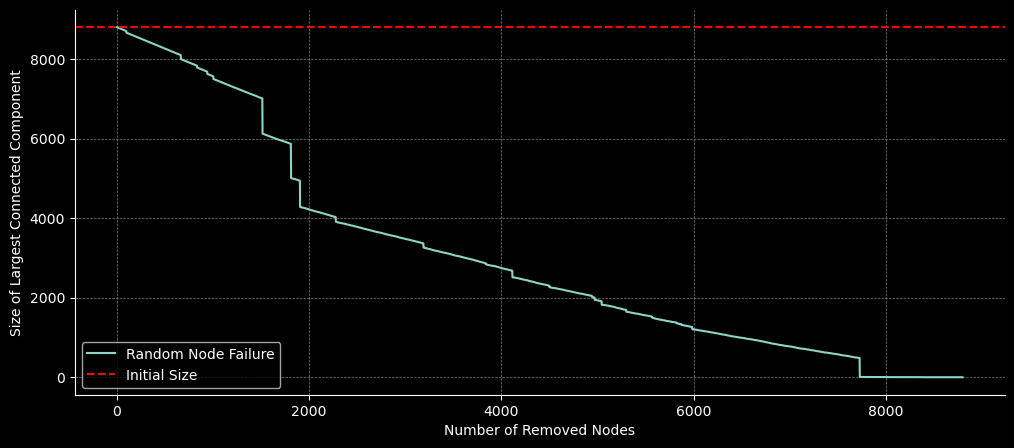

In [34]:
# Simulation one.
initial_size1, sizes1 = simulate_random_node_failure(B_main)

plt.figure(figsize=(12,5))
plt.plot(sizes1, label="Random Node Failure")
plt.axhline(y=initial_size1, color='r', linestyle='--', label="Initial Size")
plt.xlabel("Number of Removed Nodes")
plt.ylabel("Size of Largest Connected Component")
plt.legend()

# Styling
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

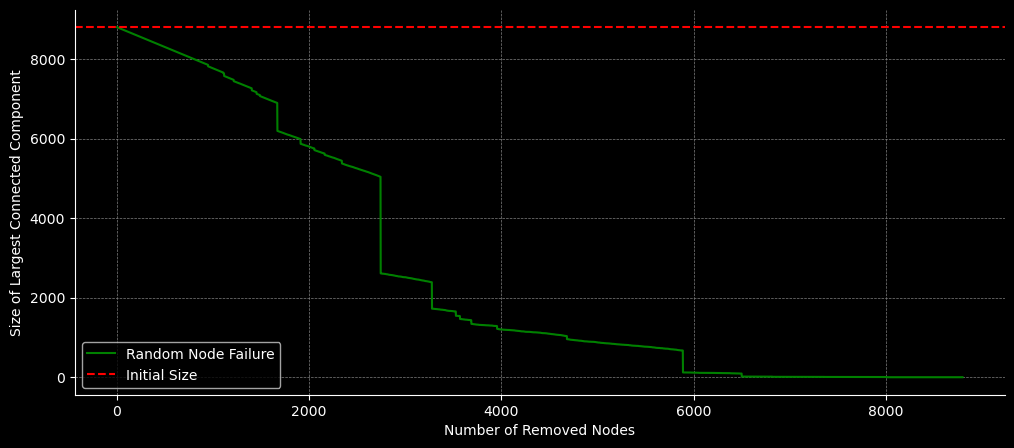

In [35]:
# Simulation two.
initial_size2, sizes2 = simulate_random_node_failure(B_main)

plt.figure(figsize=(12,5))
plt.plot(sizes2, label="Random Node Failure", color='green')
plt.axhline(y=initial_size2, color='r', linestyle='--', label="Initial Size")
plt.xlabel("Number of Removed Nodes")
plt.ylabel("Size of Largest Connected Component")
plt.legend()

# Styling
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

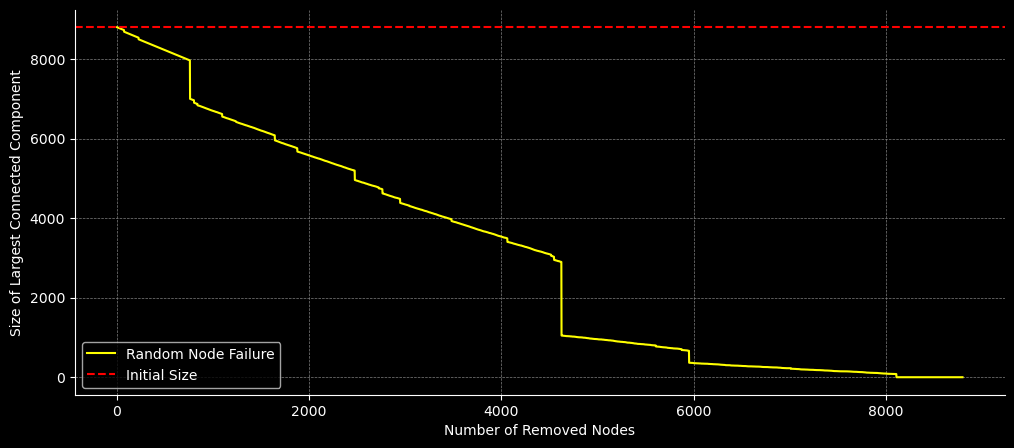

In [36]:
# Simulation three.
initial_size3, sizes3 = simulate_random_node_failure(B_main)

plt.figure(figsize=(12,5))
plt.plot(sizes3, label="Random Node Failure", color='yellow')
plt.axhline(y=initial_size3, color='r', linestyle='--', label="Initial Size")
plt.xlabel("Number of Removed Nodes")
plt.ylabel("Size of Largest Connected Component")
plt.legend()

# Styling
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

^

In the three plots above, we can see the number of randomly removed nodes along the x-axis and the size of the largest remaining connected component (section of the original graph) along the y-axis. If we define a catastrophic network failure as 50% of the nodes remaining attached, then when the y-axis reaches ~4000 would be the amount of removed nodes necessary to cause the network to fail. In the three plots above, this would be ~2200, ~2800 and ~3500 nodes respectively.

Let's define another function which tells us the average amount of nodes needed to be removed to cause a network failure.

In [37]:
def avg_network_failure(G, iters=10):
    """
    A looping function which takes a graph and 
    returns the average amount of nodes needed to
    break the network.
    Break being defined here as 50% of the nodes remaining.
       
    G = input graph.
    iters = number of iterations for the loop to iterate.
    """
    G_copy= G.copy()
        
    nodes_removed=[]
    for i in range(iters):
        initial_size, sizes = simulate_random_node_failure(G_copy)
        for j, nodes in enumerate(sizes):
            if nodes <= 4000:
                nodes_removed.append(j)
                break
                    
    return sum(nodes_removed)/len(nodes_removed)

In [38]:
average_nodes_removed = avg_network_failure(B_main, iters=45)

In [39]:
print(f'Average nodes needed to catastrophically break the network:\n',
      f'{average_nodes_removed:.2f}')

Average nodes needed to catastrophically break the network:
 2750.09


^

Given the bipartite nature of our dataset, this high number is to be expected, since most of the connections are simply one contributor connecting to an organisation.

However, our brief foray into robustness checks is evidence that the network is relatively resilient to random attacks.

# Summary
---

This project set out to use the popular Python library NetworkX to analyze a network of GitHub contributors and organisations. The exploration covered diverse aspects, including network structure, centrality measures, bipartite relationships, cliques, and robustness. Social network analysis is valuable in many ways, offering an understanding of collaboration patterns, identifying key players, and revealing the overall dynamics of our GitHub community.

- In the **overview** section we were already able to see the reach that large companies like 'Microsoft' and 'Azure' have on the network, with over half of all connections leading directly to them. We saw that most members only contribute to one organisation. We decided to drop the NULL valued data since there was no evidence-driven method to fill-in the empty records. Additionally, deciding to ignore the duplicates was a calculated risk taken in this project, future work could find ways in incorporate valid duplicates.
- During the **construction** process we used the 'bipartite' algorithm found within NetworkX, and we visualized our whole graph.
- Appling some **basic measures** like 'Diameter', 'Density' and 'Radius' we were able to get a broad view of our dataset. We discovered quantifiable results to align with our previous visualization, like the average clustering coefficient being fairly high, telling us numerically that our network tends to form tightly knitted groups as seen in the flower-like structures in our graph.
- While investigating **centrality**, it became immediately evident that the 'microsoft' node was playing a major role in the network, proving to be the top entry in all of our measures of centrality. We saw that out of the contributors, two names rose to the fore - 'Daniel' and 'Thomas Watson', suggesting that these are pivotal members in our community.
- After projecting our data on to a unipartite graph, **clique analysis** showed us that potential prominent subgroups had been created by a user's connections **through** the companies that they've worked with. In this projection, many contributors were more influential than a lot of the organisations, with names like 'Daniel', 'Thomas Watson' and 'Daniel Rosenwasser' appearing above Microsoft.
- Through our brief **percolation**/ robustness analysis we saw that due to the bipartite nature of our graph, many nodes would have to be disconnected in order to catastrophically break the network - although, this is common within bipartite graphs, which would suffer greater damage from a targeted attack than the random simulation this analysis provided.

### Pivotal nodes
The most influential organisations are clearly those displayed in the Overview section: 'microsoft', 'Azure' and 'apache'. 'microsoft' is playing an especially important role in this network - it is clearly, and by all measures, the most authoritative node within our network. Speaking of contributors, 'Daniel', 'Glaucia Lemos', 'Thomas Watson' and 'Daniel Rosenwasser' all appear to be pivotal both in terms of centrality and in their clique membership.

If a company was interested in proliferating information through our network and wished to contact an organisation, it's highly suggested that they contact Microsoft, Azure or Apache. Meanwhile, if they wished to get in touch with potentially influential individual contributors, Daniel, Glaucia Lemos, Thomas Watson and Daniel Rosenwasser would be the best statistical option.

### Future work
Improvements for future projects could include: 
- Finding ways to use NULL values and duplicated (or seemingly duplicated) entries. In this project we discarded all NULL and duplicate entries in our data, further investigation into the collection of the data may have uncovered reasonable explanations or provided adequate replacements.
- Delving deeper into community detection. This could provide insights into distinct collaboration communities and their dynamics.
- Exploring the application of machine learning models for predictive analysis. This could involve predicting future collaborations, identifying emerging trends, or assessing the impact of specific contributors.